# The Best, the Worst and the Average
To aim is to explore the performace of regular investing strategy against the best theoretical strategy and the worst theoretical strategy.

### Investment Product:
    ISF: FTSE 100 ETF

### Limit:
    £5,000 per quarter

### Rules:
    Atleast 4 investments per year
    Can only buy

### Goal:
    Buy as many shares as possible
    
### Benchmark strategy:
    Regular investing
    

#### Useful links:

FTSE 100 Average Returns
https://www.ig.com/uk/trading-strategies/what-are-the-average-returns-of-the-ftse-100--190318


Returns calculator:
https://www.calculator.net/investment-calculator.html


Inflation calculator:
https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator


Pound-cost averaging
https://www.vanguardinvestor.co.uk/articles/latest-thoughts/how-it-works/what-is-pound-cost-averaging



In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "png"

In [2]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'png'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

In [3]:
BASE_URL = 'https://docs.google.com/spreadsheets/d/10cihRP6XxJOSrWsASfW5C7VeHufD32TS0JKCXLoWhL8/export?format=csv&{}'

UKX_sheet = BASE_URL.format('gid=134530274')
HUKX_sheet = BASE_URL.format('gid=1614447400')
ISF_sheet = BASE_URL.format('gid=1374752918')


In [4]:
# Read data
df = pd.read_csv(UKX_sheet)

In [5]:
df.head(3)

,Date,Open,High,Low,Close,Volume
0,02/01/1990 16:30:00,2442.4,2443.3,2425.5,2434.1,0
1,03/01/1990 16:30:00,2451.3,2466.2,2445.8,2463.7,0
2,04/01/1990 16:30:00,2469.6,2479.4,2451.6,2451.6,0


In [6]:
# Rename columns
df = df.rename(columns={'Unnamed: 1': 'Open'})

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'].str[:10], format="%d/%m/%Y")

# Get datetime related fields
df['month'] = df['Date'].dt.month_name()
df['year'] = df['Date'].dt.year
df['day'] = df['Date'].dt.day
df['day_name'] = df['Date'].dt.day_name()
df['weekofyear'] = df['Date'].dt.weekofyear
df['is_quarter_end'] = df['Date'].dt.is_quarter_end
df['is_quarter_start'] = df['Date'].dt.is_quarter_start
df['quarter'] = df['Date'].dt.quarter
df['avg'] = round((df['High'] + df['Low']) / 2, 2) # $\frac{high + low}{2}$

# df = df.set_index('Date')
df.head()

,Date,Open,High,Low,Close,Volume,month,year,day,day_name,weekofyear,is_quarter_end,is_quarter_start,quarter,avg
0,1990-01-02,2442.4,2443.3,2425.5,2434.1,0,January,1990,2,Tuesday,1,False,False,1,2434.40
1,1990-01-03,2451.3,2466.2,2445.8,2463.7,0,January,1990,3,Wednesday,1,False,False,1,2456.00
2,1990-01-04,2469.6,2479.4,2451.6,2451.6,0,January,1990,4,Thursday,1,False,False,1,2465.50
3,1990-01-05,2442.0,2448.7,2436.6,2444.5,0,January,1990,5,Friday,1,False,False,1,2442.65
4,1990-01-08,2445.1,2445.6,2423.8,2431.3,0,January,1990,8,Monday,2,False,False,1,2434.70


In [7]:
LIMIT = 2000000 # £20,000 per year
FEE = 995


# From 1999 to 2019, the average inflation was 2.7%
INFLATION = 2.8


jan_2020_mean_price = df.loc[(df['year'] == 2020) & (df['month'] == 'January'), 'avg'].mean()

## Utility functions

In [8]:
def get_stats(strategy_df):
    tmp = strategy_df.copy()
    
    total_shares = tmp['shares'].sum()
    amount_invested = int((LIMIT * tmp.shape[0])/100)

    value = int((total_shares * jan_2020_mean_price)/100)
    profit = value - amount_invested
    value_increase = round((profit/amount_invested)*100, 2)

    print('Total no. of Shares:', int(total_shares))
    print('Amount invested: £{:,}'.format(amount_invested))
    print('Total value of Shares in Jan 2020: £{:,}'.format(value))
    print('Total profit in {} years: £{:,}'.format(tmp.shape[0], profit))
    print('Total value increased: {}%'.format(value_increase))
    
    
    
def get_cum_shares_with_div(shares, end_quarter_price, dividend_yield=0.05):
    """
    Given an iterable shares and end of quarter prices:
    
    Calculates the cumulative shares with dividends reinvested
    using the end of quarter price.
    
    """
    result = []
    total_shares = 0

    for shares, price in zip(shares, end_quarter_price):

        total_shares += shares
        value = total_shares * price
        dividend = value * dividend_yield
        div_shares = dividend / price
        total_shares += div_shares

        result.append(total_shares)

    return result


## Strategy 1 (Benchmark) - Regular Investment, first business day of every month
This serves as the benchmark

In [9]:
monthly_limit = (LIMIT/12) - FEE

benchmark = (
        monthly_limit/(df
            .loc[
                df['Date'].isin(
                    df
                    .loc[(df['year'] >= 2001) & (df['year'] <= 2019), ['Date', 'year', 'month']]
                    .groupby(['year', 'month'])
                    .agg({'Date': min})
                    .reset_index()
                    .loc[:, 'Date']
                    .to_list()
                    ), 
                ['Date', 'avg']
            ]
        )    
        .set_index('Date')
    )

benchmark = benchmark.reset_index()
benchmark = (
    benchmark
    .groupby([benchmark['Date'].dt.year, benchmark['Date'].dt.quarter])
    .sum()
    .rename(columns={'avg': 'shares'})
)

benchmark.index = benchmark.index.set_names(['year', 'quarter'])
benchmark = benchmark.reset_index()

In [10]:
benchmark.head()

,year,quarter,shares
0,2001,1,81.077273
1,2001,2,85.996762
2,2001,3,90.340407
3,2001,4,99.193726
4,2002,1,95.822679


### Strategy Performance

In [11]:
get_stats(benchmark.groupby('year').agg({'shares': 'sum'}))

Total no. of Shares: 6669
Amount invested: £380,000
Total value of Shares in Jan 2020: £504,414
Total profit in 19 years: £124,414
Total value increased: 32.74%


## Theoritcal Perfect Strategy (Upper Limit) - Buy at the lowest price every quarter
This serves as an upper limit of how many shares it is possible to buy if we bought at the lower price every quarter.

In [12]:
quarterly_limit = (LIMIT/4) - FEE

upper_limit = (    
        (
            quarterly_limit/(df
                .loc[(df['year'] >= 2001) & (df['year'] <= 2019)]
                .groupby(['year', 'quarter'])
                .agg({'Low': min})
                .reset_index()
                .set_index('year')
                .loc[:, ['Low']]
            )
        )
        .reset_index()
        .rename(columns={'Low': 'shares'})
)


In [13]:
upper_limit.tail(3)

,year,shares
73,2019,70.483819
74,2019,71.081106
75,2019,71.241343


In [14]:
get_stats(upper_limit.groupby('year').agg({'shares': 'sum'}))

Total no. of Shares: 7200
Amount invested: £380,000
Total value of Shares in Jan 2020: £544,560
Total profit in 19 years: £164,560
Total value increased: 43.31%


## Theoritcal Worst Strategy (Lower Limit) - Buy at the highest price every quarter
This serves as an lower limit of how many shares can be bought if bought at the highest price every quarter.

In [15]:
quarterly_limit = (LIMIT/4) - FEE

lower_limit = (    
        (
            quarterly_limit/(df
                .loc[(df['year'] >= 2001) & (df['year'] <= 2019)]
                .groupby(['year', 'quarter'])
                .agg({'High': max})
                .reset_index()
                .set_index('year')
                .loc[:, ['High']]
            )
        )
        .reset_index()
        .rename(columns={'High': 'shares'})
)

In [16]:
lower_limit.tail(3)

,year,shares
73,2019,66.278342
74,2019,64.575302
75,2019,65.098364


In [17]:
get_stats(lower_limit.groupby('year').agg({'shares': 'sum'}))

Total no. of Shares: 6369
Amount invested: £380,000
Total value of Shares in Jan 2020: £481,694
Total profit in 19 years: £101,694
Total value increased: 26.76%


## Strategies Performance Plots

In [18]:
strategies = pd.DataFrame(index=pd.date_range(start='2001-01-01', end='2019-12-31', freq='Q'))

strategies['upper_limit'] = upper_limit['shares'].to_list()
strategies['benchmark'] = benchmark['shares'].to_list()
strategies['lower_limit'] = lower_limit['shares'].to_list()

strategies.head(3)

,upper_limit,benchmark,lower_limit
2001-03-31,94.515683,81.077273,78.456205
2001-06-30,93.197057,85.996762,83.231311
2001-09-30,118.253235,90.340407,87.145701


## No. of shares by year

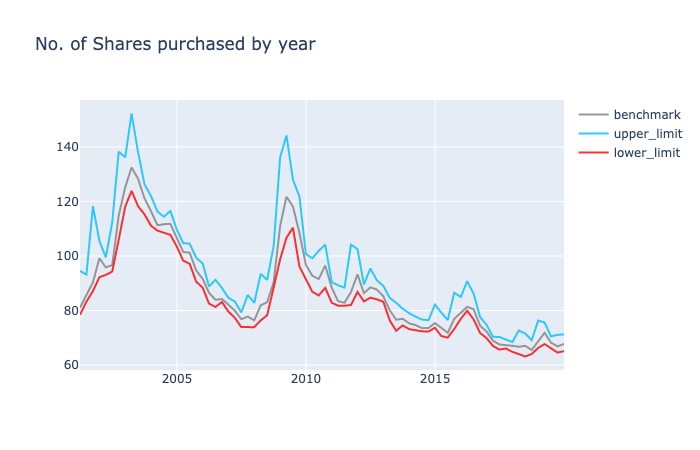

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['benchmark'],
                name="benchmark",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['upper_limit'],
                name="upper_limit",
                line_color='deepskyblue',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['lower_limit'],
                name="lower_limit",
                line_color='red',
                opacity=0.8)
             )


# Use date string to set xaxis range
fig.update_layout(
    title_text="No. of Shares purchased by year",
    # xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()

## Cumulative No. of Shares

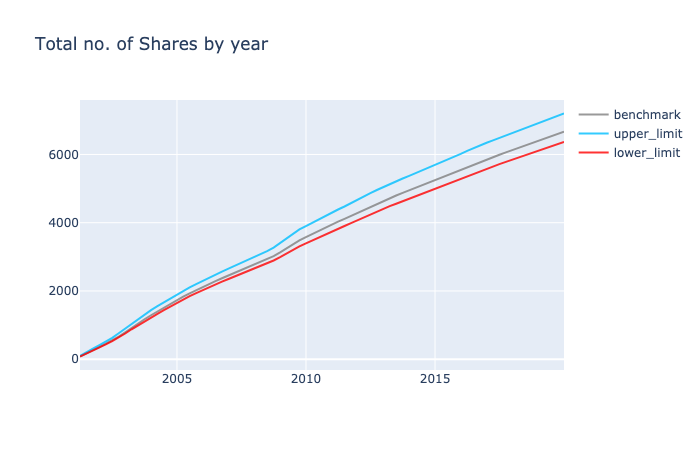

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['benchmark'].cumsum(),
                name="benchmark",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['upper_limit'].cumsum(),
                name="upper_limit",
                line_color='deepskyblue',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=strategies.index,
                y=strategies['lower_limit'].cumsum(),
                name="lower_limit",
                line_color='red',
                opacity=0.8)
             )

# Use date string to set xaxis range
fig.update_layout(
    title_text="Total no. of Shares by year",
#     xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()

## Cumulative Returns - Dividends reinvested
Dividends are assumed to be paid at the end of every quarter. The price taken into calculation will be the closing price at the end of the quarter.

In [21]:
tmp = strategies.copy().reset_index(drop=True)
quarterly_dividend_yield = 0.01

end_quarter_dates = (
    df
    .loc[(df['year'] >= 2001) & (df['year'] <= 2019)]
    .groupby(['year', 'quarter'])
    .agg({'Date': max}).reset_index().loc[:, 'Date']
)

end_quarter_prices = df.loc[df['Date'].isin(end_quarter_dates), 'Close']

end_quarter_dates
tmp['end_quarter_date'] = end_quarter_dates.to_list()
tmp['end_quarter_price'] = end_quarter_prices.to_list()


# Calculate benchmark cumulative shares and value
tmp['benchmark_cum_shares_with_div'] = get_cum_shares_with_div(
    tmp['benchmark'], 
    tmp['end_quarter_price'], 
    dividend_yield=quarterly_dividend_yield
)
tmp['benchmark_value_at_quarter_end'] = round((tmp['benchmark_cum_shares_with_div'] * tmp['end_quarter_price']) / 100, 2)


# Calculate lower_limit cumulative shares and value
tmp['lower_limit_cum_shares_with_div'] = get_cum_shares_with_div(
    tmp['lower_limit'], 
    tmp['end_quarter_price'], 
    dividend_yield=quarterly_dividend_yield
)
tmp['lower_limit_value_at_quarter_end'] = round((tmp['lower_limit_cum_shares_with_div'] * tmp['end_quarter_price']) / 100, 2)


# Calculate upper_limit cumulative shares and value
tmp['upper_limit_cum_shares_with_div'] = get_cum_shares_with_div(
    tmp['upper_limit'], 
    tmp['end_quarter_price'], 
    dividend_yield=quarterly_dividend_yield
)
tmp['upper_limit_value_at_quarter_end'] = round((tmp['upper_limit_cum_shares_with_div'] * tmp['end_quarter_price']) / 100, 2)


tmp.head()

,upper_limit,benchmark,lower_limit,end_quarter_date,end_quarter_price,benchmark_cum_shares_with_div,benchmark_value_at_quarter_end,lower_limit_cum_shares_with_div,lower_limit_value_at_quarter_end,upper_limit_cum_shares_with_div,upper_limit_value_at_quarter_end
0,94.515683,81.077273,78.456205,2001-03-30,5633.7,81.888046,4613.33,79.240767,4464.19,95.460840,5377.98
1,93.197057,85.996762,83.231311,2001-06-29,5642.5,169.563656,9567.63,164.096798,9259.16,190.544475,10751.47
2,118.253235,90.340407,87.145701,2001-09-28,4903.4,262.503104,12871.58,253.754925,12442.62,311.885687,15293.00
3,105.482275,99.193726,92.217068,2001-12-31,5217.4,365.313798,19059.88,349.431713,18231.25,421.541642,21993.51
4,99.492573,95.822679,93.058016,2002-03-28,5271.8,465.747842,24553.29,446.914626,23560.45,526.244557,27742.56


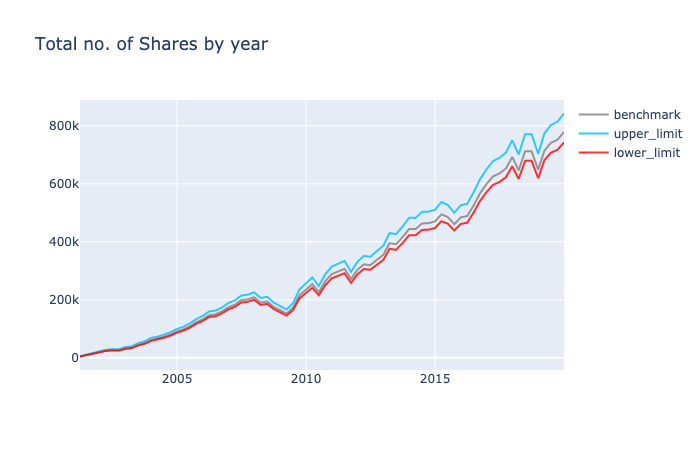

In [22]:
fig = go.Figure()


fig.add_trace(go.Scatter(
                x=tmp['end_quarter_date'],
                y=tmp['benchmark_value_at_quarter_end'],
                name="benchmark",
                line_color='grey',
                opacity=0.8)
             )


fig.add_trace(go.Scatter(
                x=tmp['end_quarter_date'],
                y=tmp['upper_limit_value_at_quarter_end'],
                name="upper_limit",
                line_color='deepskyblue',
                opacity=0.8)
             )


fig.add_trace(go.Scatter(
                x=tmp['end_quarter_date'],
                y=tmp['lower_limit_value_at_quarter_end'],
                name="lower_limit",
                line_color='red',
                opacity=0.8)
             )

# Use date string to set xaxis range
fig.update_layout(
    title_text="Total no. of Shares by year",
#     xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()

In [23]:
# tmp = df.copy()
# tmp['50_day_ma'] = df['Close'].rolling(50).mean()
# tmp['200_day_ma'] = df['Close'].rolling(200).mean()

# tmp = tmp[tmp['year'] >= 2010]

# tmp['price_below_50_day_ma'] = np.where(tmp['Close'] < tmp['50_day_ma'], 1, 0)

# tmp = tmp[tmp['price_below_50_day_ma'] == 1]